In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import data_cleaning as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import mean_squared_error, auc, roc_curve, accuracy_score, roc_auc_score, r2_score

# XGBoost Predictions

In [4]:
df = pd.read_csv("telco_data.csv")
df = df.drop(columns=["customerID"])
target = "Churn"
df[target] = df[target].apply(lambda x: 0 if x == "No" else 1)

# ordinal encoding of the dataset 
for col in dc.non_numerical_features(df):
    df, _ = dc.feature_ordinalEncoding(df, col)

In [14]:
X, y = df.drop(columns=[target]), df[target]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

## I. Naive Predictions

Accuracy: 0.81


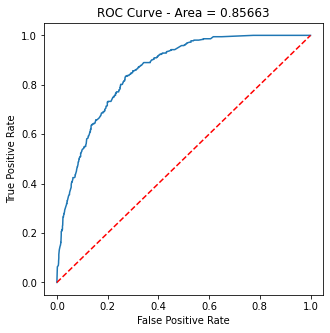

In [232]:
import warnings
warnings.filterwarnings('ignore')
# define the classifier 
clf_xgb = xgb.XGBClassifier(max_depth=5,
    learning_rate=0.01,
    n_estimators=10,
    verbosity=0,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    subsample=0.7,
)

# train the model 
clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=0)

# plot the curve 
y_pred = clf_xgb.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, y_test)))
fpr, tpr, _ = roc_curve(y_test,clf_xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));

## II. XGBoost trained using best params. found in CV with Grid Search

In [145]:
def grid_search_xgb_cv(X, y, max_depths, learning_rates, n_estimators):
    min_max_depth = float('-inf')
    min_learning_rate = float('-inf')
    min_n_estimator = float('-inf')
    best_min_score = float('-inf')
    
    for max_depth in max_depths:
        for learning_rate in learning_rates: 
            for n_estimator in n_estimators:                    
                # model definition
                clf_xgb = xgb.XGBClassifier(max_depth=max_depth,
                    learning_rate=learning_rate,
                    n_estimators=n_estimator,
                    verbosity=0,
                    objective='binary:logistic',
                    booster='gbtree',
                    n_jobs=-1,
                    subsample=0.7,
                )
                    
                # cross validation training
                min_current_score = np.min(cross_val_score(clf_xgb, X, y, scoring="roc_auc"))

                if best_min_score < min_current_score: 
                    min_max_depth = max_depth
                    min_learning_rate = learning_rate
                    min_n_estimator = n_estimator
                    best_min_score = min_current_score
    
    print("Best min score: {:.2f}".format(best_min_score))
    return {'max_depth': min_max_depth, 'learning_rate': min_learning_rate, 'n_estimator': min_n_estimator}

In [142]:
best_xgb_params = grid_search_xgb_cv(X_train, y_train, max_depths=[1, 3, 5, 7], 
                                    learning_rates=[0.5, 0.2, 0.1, 0.01, 0.001], 
                                    n_estimators=[2, 5, 10, 15])

Best min score: 0.84


Accuracy: 0.81


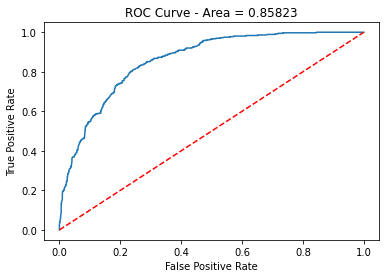

In [144]:
import warnings
warnings.filterwarnings('ignore')
# define the classifier 
clf_xgb = xgb.XGBClassifier(max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    n_estimators=best_xgb_params['n_estimator'],
    verbosity=0,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    subsample=0.7,
)

# train the model 
clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=0)

# plot the curve 
y_pred = clf_xgb.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, y_test)))
fpr, tpr, _ = roc_curve(y_test,clf_xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));

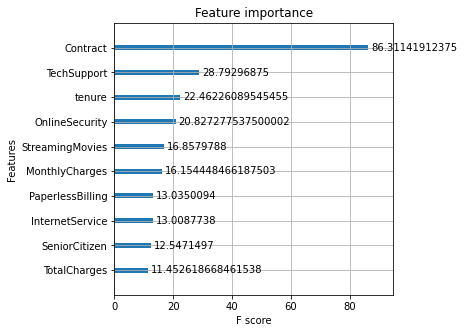

In [152]:
# plot results about the model 
xgb.plot_importance(clf_xgb, importance_type='gain', max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [155]:
selected_features = ['Contract', 'TechSupport', 'tenure', 'OnlineSecurity', 'StreamingMovies', 'MonthlyCharges',
                    'PaperlessBilling', 'InternetService', 'SeniorCitizen', 'TotalCharges']

In [156]:
best_xgb_params = grid_search_xgb_cv(X_train[selected_features], y_train, max_depths=[1, 3, 5, 7], 
                                    learning_rates=[0.5, 0.2, 0.1, 0.01, 0.001], 
                                    n_estimators=[2, 5, 10, 15])

Best min score: 0.84


Accuracy: 0.81


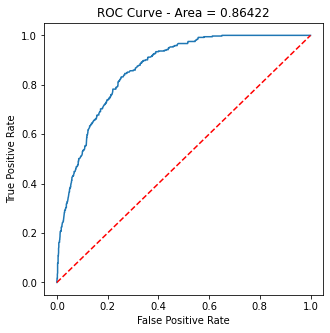

In [158]:
import warnings
warnings.filterwarnings('ignore')
# define the classifier 
clf_xgb = xgb.XGBClassifier(max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    n_estimators=best_xgb_params['n_estimator'],
    verbosity=0,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    subsample=0.7,
)

# train the model 
clf_xgb.fit(X_train[selected_features], y_train,
        eval_set=[(X_valid[selected_features], y_valid)],
        early_stopping_rounds=100,
        verbose=0)

# plot the curve 
y_pred = clf_xgb.predict(X_test[selected_features])
print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, y_test)))
fpr, tpr, _ = roc_curve(y_test,clf_xgb.predict_proba(X_test[selected_features])[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));

## III. Create a "Trainer" for XGBoost classification problems

In [3]:
import warnings
import pandas as pd
import XGBoost_trainer
warnings.filterwarnings('ignore')

Accuracy: 0.80
MCC Score: 0.43
F1 Score: 0.54


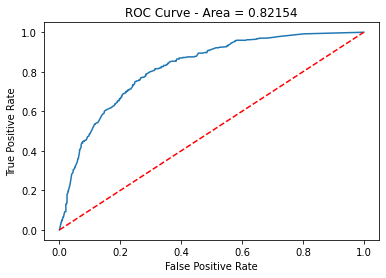

In [4]:
df = pd.read_csv("telco_data.csv")
df = df.drop(columns=["customerID"])
target = "Churn"
df[target] = df[target].apply(lambda x: 0 if x == "No" else 1)

XGBoost = XGBoost_trainer.XGBoost_classifier_model(df, 'Churn')
XGBoost.train_model(end_evaluation=True)